In [1]:
import yfinance as yf
import bs4 as bs
import pickle
import requests
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import tqdm

# Get data
## Tickers

In [6]:
html = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(html.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})

tickers = []
for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        ticker = ticker[:-1]
        tickers.append(ticker)
pickle.dump(tickers, open('data/sp500_tickers.pkl', 'wb'))

In [2]:
tickers = pickle.load(open('data/sp500_tickers.pkl', 'rb'))

In [153]:
period_start_date = '2015-01-01'
period_end_date = '2019-01-01'

## History data

In [154]:
history_data = dict()
for t in tqdm.tqdm(tickers): 
    ticker = yf.Ticker(t)
    t_h = ticker.history(period="max", auto_adjust=True)
    t_h.reset_index(inplace=True)
    t_h.columns = [x.lower() for x in t_h.columns]
    t_h['ticker'] = t
    t_h = t_h[(t_h['date'] >= period_start_date) & (t_h['date'] < period_end_date)]
    t_h = t_h[t_h['open'] != 0]
    if not t_h.empty:
        history_data[t] = t_h

 13%|█▎        | 65/505 [00:22<03:01,  2.42it/s]

- BRK.B: No data found, symbol may be delisted


 15%|█▌        | 78/505 [00:26<02:04,  3.44it/s]

- BF.B: 1d data not available for startTime=-2208988800 and endTime=1617719526. Only 100 years worth of day granularity data are allowed to be fetched per request.


100%|██████████| 505/505 [05:59<00:00,  1.40it/s]


# features
## Indicators computing random forest

In [155]:
list_m = list(range(1, 20)) + list(range(20, 241, 20))
list_m = [1]
for t_h in tqdm.tqdm(list(history_data.values())):
    for m in list_m:
        t_h_shift_one = t_h.shift(1)
        t_h_shift_m = t_h.shift(m)
        t_h_shift_m_plus_one = t_h.shift(m + 1)

        t_h[f'i_{m}'] = t_h_shift_m.apply(axis=1, func=lambda x: x['close'] / x['open'] - 1)

        data_for_cr = pd.concat([t_h_shift_one['close'], t_h_shift_m_plus_one['close']], axis=1)
        data_for_cr.columns = ['close_one', 'close_m_plus_one']
        t_h[f'cr_{m}'] = data_for_cr.apply(axis=1, func=lambda x: x['close_one'] / x['close_m_plus_one'] - 1)

        data_for_or = pd.concat([t_h['open'], t_h_shift_m['close']], axis=1)
        t_h[f'or_{m}'] = data_for_or.apply(axis=1, func=lambda x: x['open'] / x['close'] - 1)

100%|██████████| 497/497 [00:29<00:00, 17.00it/s]


In [156]:
for t_h in tqdm.tqdm(list(history_data.values())):
    cols_to_process = [x for x in t_h.columns if '_' in x]
    for col in cols_to_process:
        t_h[col] = t_h[col].astype('float32')

100%|██████████| 497/497 [00:00<00:00, 914.50it/s]


In [145]:
#pickle.dump(history_data, open('data/history_data_light.pkl', 'wb'))

,date,open,high,low,close,volume,dividends,stock splits,ticker,i_1,cr_1,or_1,i_2,cr_2,or_2,i_3,cr_3,or_3,i_4,cr_4,or_4,i_5,cr_5,or_5,i_6,cr_6,or_6,i_7,cr_7,or_7,i_8,cr_8,or_8,i_9,cr_9,or_9,i_10,cr_10,or_10,i_11,cr_11,or_11,i_12,cr_12,or_12,i_13,cr_13,or_13,i_14,cr_14,or_14,i_15,cr_15,or_15,i_16,cr_16,or_16,i_17,cr_17,or_17,i_18,cr_18,or_18,i_19,cr_19,or_19,i_20,cr_20,or_20,i_40,cr_40,or_40,i_60,cr_60,or_60,i_80,cr_80,or_80,i_100,cr_100,or_100,i_120,cr_120,or_120,i_140,cr_140,or_140,i_160,cr_160,or_160,i_180,cr_180,or_180,i_200,cr_200,or_200,i_220,cr_220,or_220,i_240,cr_240,or_240
0,1993-06-03,7.846162,7.912096,7.648360,7.747261,56603000,0.0,0.0,ALL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-06-04,7.681330,7.747264,7.549461,7.549461,12644400,0.0,0.0,ALL,-0.012605,NaN,-8.510280e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-06-07,7.450561,7.516495,7.384627,7.417594,10043800,0.0,0.0,ALL,-0.017167,-0.025532,-1.310031e-02,-0.012605,NaN,-0.038297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993-06-08,7.417593,7.450560,7.285725,7.318692,6974600,0.0,0.0,ALL,-0.004425,-0.017467,-1.329128e-07,-0.017167,-0.042553,-0.017467,-0.012605,NaN,-0.042553,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-06-09,7.351659,7.516494,7.351659,7.450560,4043200,0.0,0.0,ALL,-0.013333,-0.013333,4.504510e-03,-0.004425,-0.030568,-0.008889,-0.017167,-0.055319,-0.026201,-0.012605,NaN,-0.051063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6437,2018-12-24,75.575529,76.004128,73.508752,73.594467,1429300,0.0,0.0,ALL,0.000501,0.000501,-6.261508e-03,-0.009310,-0.013954,-0.005764,-0.007476,-0.020366,-0.020128,0.002336,-0.003868,-0.026500,0.012505,0.006936,-0.010105,-0.005518,-0.009182,0.000631,-0.019348,-0.030947,-0.015386,-0.015532,-0.032004,-0.037014,-0.022283,-0.041186,-0.038065,0.003615,-0.047250,-0.047190,-0.013768,-0.061582,-0.053215,-0.006306,-0.075810,-0.067458,-0.026589,-0.100383,-0.081597,-0.010259,-0.104720,-0.106016,0.008024,-0.097536,-0.110326,0.000905,-0.099775,-0.103187,0.015837,-0.082696,-0.105411,-0.006021,-0.092240,-0.088440,0.000000,-0.

## Indicators computing for LSTM

In [157]:
for ticker, hist in tqdm.tqdm(history_data.items()):
    history_data[ticker] = history_data[ticker][['ticker', 'date', 'open', 'close', 'i_1', 'cr_1', 'or_1']]

100%|██████████| 497/497 [00:00<00:00, 824.01it/s]


## Output computing

In [158]:
all_dates = [str(d)[:10] for d in pd.date_range(start=period_start_date, end=period_end_date).tolist()]

In [159]:
history_data_agg = pd.concat(list(history_data.values()), axis=0)

In [160]:
outputs = list()
for d in tqdm.tqdm(all_dates):
    data_one_day = history_data_agg.loc[history_data_agg['date'] == d, ['ticker', 'date', 'open', 'close']].copy()
    data_one_day['return'] = 100 * (data_one_day['close'] / data_one_day['open'] - 1)
    data_one_day = data_one_day.sort_values('return', ascending=False, inplace=False).reset_index(drop=True, inplace=False)
    data_one_day['class'] = 0
    #data_one_day.loc[:len(data_one_day) // 2, 'class'] = 1
    data_one_day.loc[data_one_day['return'] > 0, 'class'] = 1
    outputs.append(data_one_day)

100%|██████████| 1462/1462 [00:07<00:00, 202.45it/s]


In [161]:
outputs_df = pd.concat(outputs, axis=0)
outputs_df = outputs_df[['ticker', 'date', 'class']]

In [162]:
outputs_df.head()

,ticker,date,class
0,NEM,2015-01-02,1
1,ANET,2015-01-02,1
2,APA,2015-01-02,1
3,VRTX,2015-01-02,1
4,HFC,2015-01-02,1


In [163]:
for ticker, hist in tqdm.tqdm(history_data.items()):
    history_data[ticker] = pd.merge(hist, outputs_df, how='left', on=['date', 'ticker'])
    if history_data[ticker][history_data[ticker].isnull().any(axis=1)].empty:
        print(ticker)

100%|██████████| 497/497 [00:42<00:00, 11.56it/s]


In [206]:
history_data['MMM']

,ticker,date,open,close,i_1,cr_1,or_1,class
0,MMM,2015-01-02,137.615073,137.071991,NaN,NaN,NaN,0
1,MMM,2015-01-05,136.186369,133.980652,-0.003946,NaN,-0.006461,0
2,MMM,2015-01-06,134.365016,132.551971,-0.016196,-0.022553,0.002869,0
3,MMM,2015-01-07,133.596344,133.512802,-0.013493,-0.010663,0.007879,0
4,MMM,2015-01-08,134.222956,136.712753,-0.000625,0.007249,0.005319,1
...,...,...,...,...,...,...,...,...
1001,MMM,2018-12-24,168.257899,165.232971,-0.021878,-0.019372,-0.010122,0
1002,MMM,2018-12-26,165.936014,172.300369,-0.017978,-0.027918,0.004255,1
1003,MMM,2018-12-27,169.747200,176.407578,0.038354,0.042772,-0.014818,1
1004,MMM,2018-12-28,177.434393,175.177261,0.039237,0.023837,0.005821,0


## Split to train / test

In [140]:
#history_data = pickle.load(open('data/history_data.pkl', 'rb'))

In [165]:
dataset = dict()
for t, data in tqdm.tqdm(history_data.items()):
    dataset[t] = dict()
    for year in range(1994, 2020):
        dataset[t][year] = dict()
        start_date = str(year - 4) + '-01-01'
        split_date = str(year - 1) + '-01-01'
        end_date = str(year) + '-01-01'
        dataset[t][year]['train'] = data[(data['date'] > start_date) & (data['date'] < split_date)].dropna(axis=0).reset_index(drop=True)
        dataset[t][year]['test'] = data[(data['date'] >= split_date) & (data['date'] < end_date)].reset_index(drop=True)
        if dataset[t][year]['train'].empty or len(dataset[t][year]['train']) < 241  or dataset[t][year]['test'].empty:
            del dataset[t][year]

100%|██████████| 497/497 [00:49<00:00, 10.10it/s]


In [166]:
dataset['MMM'][2017]['train']

,ticker,date,open,close,i_1,cr_1,or_1,class
0,MMM,2015-01-06,134.365016,132.551971,-0.016196,-0.022553,2.868806e-03,0
1,MMM,2015-01-07,133.596344,133.512802,-0.013493,-0.010663,7.878969e-03,0
2,MMM,2015-01-08,134.222956,136.712753,-0.000625,0.007249,5.318996e-03,1
3,MMM,2015-01-09,136.896559,135.033386,0.018550,0.023967,1.344465e-03,0
4,MMM,2015-01-12,135.676725,134.298157,-0.013610,-0.012284,4.764298e-03,0
5,MMM,2015-01-13,135.543061,134.197906,-0.010161,-0.005445,9.269705e-03,0
6,MMM,2015-01-14,132.877786,133.546188,-0.009924,-0.000746,-9.837113e-03,1
7,MMM,2015-01-15,134.423473,133.395813,0.005030,-0.004856,6.569151e-03,0
8,MMM,2015-01-16,133.562893,135.350861,-0.007645,-0.001126,1.252513e-03,1
9,MMM,2015-01-20,135.952439,135.300751,0.013387,0.014656,4.444586e-03,0


## Normalization

In [167]:
from sklearn.preprocessing import RobustScaler

In [168]:
features_to_scale = [x for x in history_data['AMD'].columns if '_' in x]
scaled_features_name = [x + '_scaled' for x in features_to_scale]

In [169]:
dataset['MMM'].keys()

dict_keys([2017, 2018, 2019])

In [170]:
for t, hist in tqdm.tqdm(dataset.items()):
    for y, data in hist.items():
        scaler = RobustScaler().fit(data['train'][features_to_scale])

        scaled_train = scaler.transform(data['train'][features_to_scale]).astype('float32')
        scaled_train = pd.DataFrame(scaled_train, columns=scaled_features_name)
        data['train'] = pd.concat([data['train'][['date', 'ticker', 'class']], scaled_train], axis=1)
        
        scaled_test = scaler.transform(data['test'][features_to_scale]).astype('float32')
        scaled_test = pd.DataFrame(scaled_test, columns=scaled_features_name)
        data['test'] = pd.concat([data['test'][['date', 'ticker', 'class']], scaled_test], axis=1)

        

100%|██████████| 497/497 [00:16<00:00, 30.54it/s]


In [171]:
dataset['MMM'][2017]['train']

,date,ticker,class,i_1_scaled,cr_1_scaled,or_1_scaled
0,2015-01-06,MMM,0,-1.602836,-1.806672,0.448315
1,2015-01-07,MMM,0,-1.339798,-0.867358,1.214855
2,2015-01-08,MMM,1,-0.087506,0.547779,0.823187
3,2015-01-09,MMM,0,1.778562,1.868633,0.215096
4,2015-01-12,MMM,0,-1.351150,-0.995391,0.738320
5,2015-01-13,MMM,0,-1.015464,-0.455069,1.427633
6,2015-01-14,MMM,1,-0.992448,-0.083879,-1.495651
7,2015-01-15,MMM,0,0.462876,-0.408582,1.014457
8,2015-01-16,MMM,1,-0.770638,-0.113865,0.201028
9,2015-01-20,MMM,0,1.276111,1.132989,0.689405


# Train model

In [172]:
data_train_one_year = list()
data_test_one_year = list()
y_train_one_year = list()
y_test_one_year = list()
history_size = 240
year = 2017
for t in tqdm.tqdm(dataset.keys()):
    data_one_year = dataset[t].get(year)
    if not data_one_year:
        continue
        
    train_tmp = data_one_year['train'].reset_index(drop=True)
    for i in range(history_size, len(train_tmp)):
        one_train_data = train_tmp.loc[i - history_size + 1: i, ['ticker', 'date', 'i_1_scaled', 'cr_1_scaled', 'or_1_scaled']]
        y_train = train_tmp.loc[i, ['ticker', 'date', 'class']]
        data_train_one_year.append(one_train_data)        
        y_train_one_year.append(y_train)

    test_tmp = data_one_year['test']
    data_tmp = pd.concat([train_tmp, test_tmp], axis=0).reset_index(drop=True)
    for i in range(len(train_tmp), len(data_tmp)):
        one_test_data = data_tmp.loc[i - history_size + 1: i, ['ticker', 'date', 'i_1_scaled', 'cr_1_scaled', 'or_1_scaled']]
        y_test = data_tmp.loc[i, ['ticker', 'date', 'class']]
        data_test_one_year.append(one_test_data)        
        y_test_one_year.append(y_test)

100%|██████████| 497/497 [03:36<00:00,  2.30it/s]


In [173]:
dataset_2010 = {'X_train': data_train_one_year, 'X_test': data_test_one_year, 'y_train': y_train_one_year, 'y_test': y_test_one_year}

In [174]:
X_train_lstm = np.array([x[['i_1_scaled', 'cr_1_scaled', 'or_1_scaled']].values for x in dataset_2010['X_train']])
y_train_lstm = np.array([x['class'] for x in dataset_2010['y_train']])

In [175]:
X_test_lstm = np.array([x[['i_1_scaled', 'cr_1_scaled', 'or_1_scaled']].values for x in dataset_2010['X_test']])
y_test_lstm = np.array([x['class'] for x in dataset_2010['y_test']])

In [117]:
#pickle.dump(dataset_2010, open('data/dataset_2010.pkl', 'wb'))

In [204]:
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Dropout, Dense, Input, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import optimizers

model_folder = '/content/drive/My Drive/trading/models'
def create_lstm_model():
    #inputs = Input(shape=(240,3))
    #x = LSTM(25, return_sequences=False)(inputs)
    #x = Dropout(0.1)(x)
    #outputs = Dense(1, activation='sigmoid')(x)
    #model = Model(inputs=inputs, outputs=outputs)


    model = Sequential()
    model.add(Input(shape=(240, 3)))
    model.add(LSTM(units=25, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(units=25, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-3), metrics=['accuracy'], )
    model.summary()
    return model

def callbacks_req():
    filepath = model_folder + "/model-" + '-' + str(year) + "-E{epoch:02d}.h5"
    model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=False, save_freq=1)
    earlyStopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, mode="min", min_lr=1e-5, verbose=1)
    return [earlyStopping, reduce_lr]

In [205]:
model = create_lstm_model()
callbacks = callbacks_req()
model.fit(X_train_lstm,
          y_train_lstm,
          validation_data=(X_test_lstm, y_test_lstm),
          epochs=1000,
          #validation_split=0.2,
          callbacks=callbacks,
          batch_size=512
          )

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 240, 25)           2900      
_________________________________________________________________
dropout_9 (Dropout)          (None, 240, 25)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 25)                5100      
_________________________________________________________________
dropout_10 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 26        
Total params: 8,026
Trainable params: 8,026
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
10/10 [==============================] - 45s 4s/step - loss: 0.6893 - accuracy: 0.5357 - val_loss: 0.7111

KeyboardInterrupt: 

In [178]:
y_pred = model.predict(X_test_lstm)

In [179]:
y_class_test = pd.concat([x.to_frame().T for x in dataset_2010['y_test']], axis=0)

In [180]:
y_class_test['y_pred'] = y_pred

<AxesSubplot:>

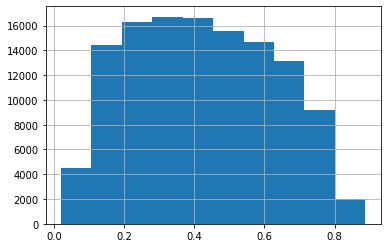

In [181]:
y_class_test['y_pred'].hist()

In [183]:
y_class_test['class'].value_counts()

1    64478
0    58498
Name: class, dtype: int64

In [184]:
y_class_test[y_class_test['date'] == '2016-01-12'].sort_values('y_pred', ascending=False)[:10]

,ticker,date,class,y_pred
256,NEM,2016-01-12,0,0.745956
256,ABC,2016-01-12,0,0.586802
256,ATO,2016-01-12,0,0.564146
256,LYB,2016-01-12,1,0.561273
256,UAA,2016-01-12,1,0.549663
256,NVR,2016-01-12,1,0.524677
256,AMCR,2016-01-12,0,0.516497
256,VFC,2016-01-12,1,0.506596
256,CZR,2016-01-12,0,0.501963
256,NVDA,2016-01-12,0,0.489958


In [185]:
history_data_agg['ret'] = 100 * (history_data_agg['close'] / history_data_agg['open'] - 1)

In [186]:
global_result = pd.merge(y_class_test, history_data_agg, how='left', on=['ticker', 'date'])

In [202]:
global_result[global_result['date'] == '2016-06-13'].sort_values('y_pred', ascending=False)[:10]

,ticker,date,class,y_pred,open,close,i_1,cr_1,or_1,ret
26571,CSCO,2016-06-13,0,0.835762,24.705442,24.594580,0.008336,-0.003775,-0.002067,-0.448737
19011,AVGO,2016-06-13,0,0.835108,135.472803,135.362823,-0.008325,-0.020227,-0.004229,-0.081182
77727,MDLZ,2016-06-13,0,0.821712,40.756743,39.827991,0.006708,-0.004423,0.003999,-2.278767
20019,CDNS,2016-06-13,0,0.819129,24.590000,24.590000,0.002435,-0.006436,-0.004453,0.000000
41187,ETR,2016-06-13,0,0.816184,64.961729,64.549797,0.002677,-0.000381,0.002543,-0.634115
94107,QRVO,2016-06-13,1,0.804006,53.509998,53.689999,-0.024729,-0.036383,-0.009624,0.336386
118299,WEC,2016-06-13,0,0.801754,53.570097,53.484550,0.005467,0.003370,0.001439,-0.159691
121323,XLNX,2016-06-13,0,0.794511,42.922838,42.628342,0.004298,-0.006379,-0.001926,-0.686106
101919,SO,2016-06-13,0,0.791799,40.974464,40.966431,0.008087,0.004916,-0.002152,-0.019605
115527,VTRS,2016-06-13,1,0.779904,44.150002,44.770000,0.003154,-0.026879,-0.008534,1.404301


# Take only best yesterday tickers as prediction

In [207]:
all_data = pd.DataFrame()
for hist in history_data.values():
    all_data = pd.concat([all_data, hist], axis=0)

In [210]:
all_data = all_data.dropna(axis=0).reset_index(drop=True)

In [214]:
all_data['ret'] = round(100 * (all_data['close'] / all_data['open'] - 1), 2)

In [222]:
all_data[all_data['date'] == '2016-07-15'].sort_values('i_1', ascending=False).head(10)

,ticker,date,open,close,i_1,cr_1,or_1,class,ret
485936,WMB,2016-07-15,18.279215,17.987608,0.048889,0.061628,9.322241e-03,0,-1.60
236677,INFO,2016-07-15,35.400182,34.767330,0.039687,-0.005817,-2.507686e-03,0,-1.79
325848,NEM,2016-07-15,37.590842,37.672878,0.036355,0.018102,-9.130139e-03,1,0.22
379938,QRVO,2016-07-15,59.500000,59.419998,0.030761,0.046586,3.203484e-03,0,-0.13
267207,KMI,2016-07-15,16.955507,16.955507,0.029557,0.034142,6.220077e-03,0,0.00
262187,K,2016-07-15,72.787684,73.230522,0.027952,0.026591,1.757971e-03,1,0.61
126886,CSX,2016-07-15,27.082392,26.588291,0.027228,0.029777,-1.235572e-07,0,-1.82
157006,EBAY,2016-07-15,25.363974,25.499506,0.024754,0.038217,4.601239e-03,1,0.53
194709,FTV,2016-07-15,42.497353,42.045952,0.024637,0.018767,4.072197e-03,0,-1.06
450915,UAL,2016-07-15,47.509998,47.430000,0.023967,0.043393,-7.105541e-03,0,-0.17


In [148]:
dataset['ABBV'][2015]['train'].tail()

,date,open,high,low,close,volume,dividends,stock splits,ticker,i_1,cr_1,or_1,i_2,cr_2,or_2,i_3,cr_3,or_3,i_4,cr_4,or_4,i_5,cr_5,or_5,i_6,cr_6,or_6,i_7,cr_7,or_7,i_8,cr_8,or_8,i_9,cr_9,or_9,i_10,cr_10,or_10,i_11,cr_11,or_11,i_12,cr_12,or_12,i_13,cr_13,or_13,i_14,cr_14,or_14,i_15,cr_15,or_15,i_16,cr_16,or_16,i_17,cr_17,or_17,i_18,cr_18,or_18,i_19,cr_19,or_19,i_20,cr_20,or_20,i_40,cr_40,or_40,i_60,cr_60,or_60,i_80,cr_80,or_80,i_100,cr_100,or_100,i_120,cr_120,or_120,i_140,cr_140,or_140,i_160,cr_160,or_160,i_180,cr_180,or_180,i_200,cr_200,or_200,i_220,cr_220,or_220,i_240,cr_240,or_240,i_1_scaled,cr_1_scaled,or_1_scaled,i_2_scaled,cr_2_scaled,or_2_scaled,i_3_scaled,cr_3_scaled,or_3_scaled,i_4_scaled,cr_4_scaled,or_4_scaled,i_5_scaled,cr_5_scaled,or_5_scaled,i_6_scaled,cr_6_scaled,or_6_scaled,i_7_scaled,cr_7_scaled,or_7_scaled,i_8_scaled,cr_8_scaled,or_8_scaled,i_9_scaled,cr_9_scaled,or_9_scaled,i_10_scaled,cr_10_scaled,or_10_scaled,i_11_scaled,cr_11_scaled,or_11_scaled,i_12_scaled,cr_12_scaled,or_12_scaled,i_13_scaled,cr_13_scaled,or_13_scaled,i_14_scaled,cr_14_scaled,or_14_scaled,i_15_scaled,cr_15_scaled,or_15_scaled,i_16_scaled,cr_16_scaled,or_16_scaled,i_17_scaled,cr_17_scaled,or_17_scaled,i_18_scaled,cr_18_scaled,or_18_scaled,i_19_scaled,cr_19_scaled,or_19_scaled,i_20_scaled,cr_20_scaled,or_20_scaled,i_40_scaled,cr_40_scaled,or_40_scaled,i_60_scaled,cr_60_scaled,or_60_scaled,i_80_scaled,cr_80_scaled,or_80_scaled,i_100_scaled,cr_100_scaled,or_100_scaled,i_120_scaled,cr_120_scaled,or_120_scaled,i_140_scaled,cr_140_scaled,or_140_scaled,i_160_scaled,cr_160_scaled,or_160_scaled,i_180_scaled,cr_180_scaled,or_180_scaled,i_200_scaled,cr_200_scaled,or_200_scaled,i_220_scaled,cr_220_scaled,or_220_scaled,i_240_scaled,cr_240_scaled,or_240_scaled
247,2013-12-24,39.233028,39.240462,38.861362,38.920830,1747000.0,0.0,0.0,ABBV,-0.002845,-0.000190,0.003803,-0.003411,-0.000950,0.003613,-0.010900,-0.032032,2.849773e-03,0.029178,-0.019578,-0.028350,0.003743,-0.014802,-0.015849,-0.000936,0.004010,-0.011055,0.001338,0.003627,0.007829,-0.003234,-0.001709,0.007444,0.000000,0.008439,0.002088,0.017366,0.026753,0.012274,-0.004665,0.023954,0.030658,0.023520,0.056672,0.027848,0.006880,0.058587,0.060691,-0.001608,0.052232,0.062613,0.017097,0.086588,0.056234,-0.002062,0.085243,0.090721,0.000413,0.089741,0.089370,-0.011878,0.081893,0.093886,0.004547,0.086140,0.086008,-0.012041,0.074377,0.090271,0.005903,0.066532,0.067989,0.004717,0.196788,0.190596,-0.003508,0.244805,0.249833,0.004655,0.172455,0.175096,0.006360,0.267851,0.258075,0.006478,0.243990,0.235517,-0.033770,0.192192,0.235801,0.022743,0.269962,0.243521,-0.014058,0.434481,0.459306,-0.007750,0.490672,0.513037,0.007740,0.608240,0.602434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
248,2013-12-26,39.091796,39.441163,38.905963,39.389130,2401500.0,0.0,0.0,ABBV,-0.007958,-0.004184,0.004393,-0.002845,-0.004374,0.000190,-0.003411,-0.005130,-1.209058e-07,-0.010900,-0.036082,-0.000760,0.029178,-0.023681,-0.031848,0.003743,-0.018925,-0.019392,-0.000936,-0.000191,-0.014615,0.001338,-0.000573,0.004201,-0.003234,-0.005886,0.003817,0.000000,0.004219,-0.001519,0.017366,0.022456,0.008630,-0.004665,0.019669,0.026948,0.023520,0.052251,0.024148,0.006880,0.054157,0.056873,-0.001608,0.047829,0.058788,0.017097,0.082042,0.052431,-0.002062,0.080702,0.086795,0.000413,0.085181,0.085449,-0.011878,0.077366,0.089948,0.004547,0.081595,0.082099,0.006265,0.059490,0.056236,0.022093,0.181122,0.158595,-0.009535,0.239887,0.245918,-0.007547,0.165746,0.186841,0.018182,0.248064,0.225996,0.006404,0.225685,0.217080,0.020766,0.225967,0.210477,-0.005067,0.233626,0.239618,-0.000807,0.447693,0.454053,-0.009785,0.500997,0.525893,0.

In [96]:
pickle.dump(dataset, open('data/dataset.pkl', 'wb'))

KeyboardInterrupt: 

## Output

In [79]:
history_data['ABT'][240:250]

,date,open,high,low,close,volume,dividends,stock splits,ticker,i_1,cr_1,or_1,i_2,cr_2,or_2,i_3,cr_3,or_3,i_4,cr_4,or_4,i_5,cr_5,or_5,i_6,cr_6,or_6,i_7,cr_7,or_7,i_8,cr_8,or_8,i_9,cr_9,or_9,i_10,cr_10,or_10,i_11,cr_11,or_11,i_12,cr_12,or_12,i_13,cr_13,or_13,i_14,cr_14,or_14,i_15,cr_15,or_15,i_16,cr_16,or_16,i_17,cr_17,or_17,i_18,cr_18,or_18,i_19,cr_19,or_19,i_20,cr_20,or_20,i_40,cr_40,or_40,i_60,cr_60,or_60,i_80,cr_80,or_80,i_100,cr_100,or_100,i_120,cr_120,or_120,i_140,cr_140,or_140,i_160,cr_160,or_160,i_180,cr_180,or_180,i_200,cr_200,or_200,i_220,cr_220,or_220,i_240,cr_240,or_240
2716,1990-12-12,2.349335,2.401982,2.342754,2.395401,7201590,0.0,0.0,ABT,-0.005540,-0.011019,-5.570478e-03,0.013966,0.000000,-1.652858e-02,0.002793,-0.002778,-5.570478e-03,0.002785,0.008427,-0.008333,0.011363,0.002793,0.002809,0.017045,0.019886,-2.793019e-03,-0.005650,0.028653,0.014205,0.035608,0.062130,2.292285e-02,-0.008798,0.049707,0.056214,0.000000,0.055882,4.386006e-02,0.005917,0.065281,0.050000,0.000000,0.058996,0.059347,0.005935,0.058996,0.053097,0.014970,0.074850,0.053097,-0.014749,0.062130,0.068862,-0.011696,0.062130,0.056214,-0.014577,0.043605,5.621355e-02,0.011765,0.046647,0.037791,0.020833,0.065281,0.040817,-0.002959,0.062130,0.059347,-0.009146,0.091186,0.098462,0.034162,0.117124,0.077542,-0.021807,0.124086,0.142743,-0.014124,0.013571,0.028141,-0.015337,0.112457,0.123491,0.006849,0.241990,0.226669,0.009294,0.353213,0.328327,0.009634,0.406320,0.385143,0.011834,0.436771,0.414843,0.001945,0.414497,0.409348,0.014652,NaN,0.316851
2717,1990-12-13,2.408561,2.441465,2.369076,2.375657,3946528,0.0,0.0,ABT,0.019608,0.013928,5.493841e-03,-0.005540,0.002755,1.949868e-02,0.013966,0.013928,8.264324e-03,0.002793,0.011111,0.019499,0.002785,0.022472,0.016666,0.011363,0.016760,2.808962e-02,0.017045,0.034092,0.022346,-0.005650,0.042980,3.977278e-02,0.035608,0.076924,0.048710,-0.008798,0.064328,8.284025e-02,0.000000,0.070588,0.070175,0.005917,0.080119,0.076470,0.000000,0.073746,0.086053,0.005935,0.073746,0.079645,0.014970,0.089821,0.079645,-0.014749,0.076924,0.095808,-0.011696,0.076924,8.284025e-02,-0.014577,0.058140,0.082840,0.011765,0.061225,0.063953,0.020833,0.080119,0.067055,0.012384,0.120001,0.119265,-0.020833,0.098670,0.118137,-0.003268,0.165150,0.206122,-0.025641,0.048301,0.075635,0.000000,0.145521,0.155413,0.001712,0.250722,0.264042,-0.011050,0.354372,0.377029,-0.003788,0.412302,0.414661,0.007812,0.442585,0.442078,0.011673,0.436983,0.430984,0.001802,0.342672,0.345192
2718,1990-12-14,2.382238,2.395400,2.336173,2.355915,4375131,0.0,0.0,ABT,-0.013661,-0.008242,2.770150e-03,0.019608,0.005571,-5.495110e-03,-0.005540,-0.005510,8.356666e-03,0.013966,0.005571,-0.002755,0.002793,0.002777,0.008357,0.002785,0.014045,5.555042e-03,0.011363,0.008380,0.016854,0.017045,0.025568,1.117302e-02,-0.005650,0.034384,0.028409,0.035608,0.068047,3.724904e-02,-0.008798,0.055555,0.071006,0.000000,0.061764,0.058479,0.005917,0.071216,0.064705,0.000000,0.064896,0.074184,0.005935,0.064896,0.067846,0.014970,0.080838,0.067846,-0.014749,0.068047,8.383194e-02,-0.011696,0.068047,0.071006,-0.014577,0.049419,0.071006,0.011765,0.052478,0.052326,0.042683,0.103975,0.058479,-0.009375,0.102862,0.147781,-0.049020,0.189645,0.250332,0.023529,0.060940,0.045537,-0.006173,0.139629,0.135689,0.011905,0.246773,0.229216,0.007547,0.358217,0.369631,-0.001898,0.395335,0.399201,0.003861,0.422377,0.415345,0.003846,0.411435,0.409923,-0.003591,0.326815,0.332887
2719,1990-12-17,2.336173,2.349335,2.323012,2.336173,4677202,0.0,0.0,ABT,-0.011050,-0.008310,-8.379763e-03,-0.013661,-0.016484,-1.662015e-02,0.019608,-0.002785,-2.472559e-02,-0.005540,-0.013774,-0.011142,0.013966,-0.002785,-0.022038,0.002793,-0.005556,-1.114166e-02,0.002785,0.005618,-0.013889,0.011363,0.000000,-2.808913e-03,0.017045,0.017046,-0.008380,-0.005650,0.025788,8.523117e-03,0.035608,0.059172,0.017192,-0.008798,0.046784,0.050296,0.000000,0.052941,0.038012,0.005917,0.062314,0.044118,0.000000,0.056047,0.053412,0.005935,0.056047,0.047197,0.014970,0.071